In [1]:
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress


In [66]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52918,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:53113,Total threads: 2
Dashboard: http://127.0.0.1:53120/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:52923,


# Problem 1

### Create SST Dataset

In [3]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)


In [4]:
file_list

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1980/e5.moda.an.sfc.128_034_sstk.ll025sc.1980010100_1980120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1981/e5.moda.an.sfc.128_034_sstk.ll025sc.1981010100_1981120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1982/e5.moda.an.sfc.128_034_sstk.ll025sc.1982010100_1982120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1983/e5.moda.an.sfc.128_034_sstk.ll025sc.1983010100_1983120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1984/e5.moda.an.sfc.128_034_sstk.ll025sc.1984010100_1984120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1985/e5.moda.an.sfc.128_034_sstk.ll025sc.1985010100_1985120100.nc',
 'https://rda.ucar.edu/thre

In [5]:
ds = xr.open_mfdataset(file_list, chunks={'time': '100MB'}).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [6]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 1979010100 1979020100 ... 2021110100 2021120100
    SSTK       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 07:46:57 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 07:46:58 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [7]:
gb = ds.SSTK.groupby('time.month')
gb

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [8]:
anom = gb - gb.mean(dim='time')

In [9]:
anom

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
array([[[            nan,             nan,             nan, ...,
         -8.17871094e-03, -1.33056641e-02, -1.83410645e-02],
        [            nan,             nan,             nan, ...,
         -1.33972168e-02, -2.06604004e-02, -2.74963379e-02],
        [            nan,             nan,             nan, ...,
         -1.77917480e-02, -2.50244141e-02, -3.21960449e-02],
        ...,
        [-3.00506592e-01, -3.01300049e-01, -3.02459717e-01, ...,
                     nan,             nan,             nan],
        [-8.54736328e-01, -8.40728760e-01, -8.27301025e-01, ...,
                     nan,             nan,             nan],
        [-8.32458496e-01, -8.32183838e-01, -8.46466064e-01, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -5.18798828e-04, -7.01904297e-04, -8.85009766e-04],
        [            nan,             nan,             nan, ...,
         -7.01904297e-04, -1.92260742e-03, -3.54003906e-03],
        [            nan,             nan,             nan, ...,
         -1.58691406e-03, -4.24194336e-03, -6.86645508e-03],
...
                     nan,             nan,             nan],
        [-6.92749023e-03, -8.08715820e-03, -9.15527344e-03, ...,
                     nan,             nan,             nan],
        [-8.54492188e-04, -1.40380859e-03, -1.40380859e-03, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          9.37194824e-02,  6.34460449e-02,  3.24096680e-02],
        [            nan,             nan,             nan, ...,
          7.76062012e-02,  5.41687012e-02,  3.11279297e-02],
        [            nan,             nan,             nan, ...,
          7.62939453e-02,  5.80749512e-02,  4.01306152e-02],
        ...,
        [-1.10382080e-01, -8.47473145e-02, -6.00891113e-02, ...,
                     nan,             nan,             nan],
        [-3.03283691e-01, -2.89428711e-01, -2.75299072e-01, ...,
                     nan,             nan,             nan],
        [-1.43981934e-01, -1.37939453e-01, -1.40350342e-01, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

#### Mask data

In [10]:
mask_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
mask = xr.open_dataset(mask_url).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [11]:
mask_drop = mask.squeeze('time')
mask_time = mask_drop.expand_dims(time=anom.time)

In [12]:
mask_SST = anom.where(mask_time.LSM==0., np.nan)

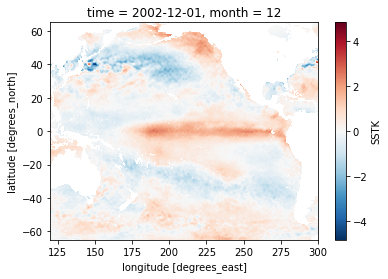

In [13]:
mask_SST.sel(time='2002-12-01', method='nearest').plot()

In [14]:
mask_SST

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
array([[[            nan,             nan,             nan, ...,
         -8.17871094e-03, -1.33056641e-02, -1.83410645e-02],
        [            nan,             nan,             nan, ...,
         -1.33972168e-02, -2.06604004e-02, -2.74963379e-02],
        [            nan,             nan,             nan, ...,
         -1.77917480e-02, -2.50244141e-02, -3.21960449e-02],
        ...,
        [-3.00506592e-01, -3.01300049e-01, -3.02459717e-01, ...,
                     nan,             nan,             nan],
        [-8.54736328e-01, -8.40728760e-01, -8.27301025e-01, ...,
                     nan,             nan,             nan],
        [-8.32458496e-01, -8.32183838e-01, -8.46466064e-01, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -5.18798828e-04, -7.01904297e-04, -8.85009766e-04],
        [            nan,             nan,             nan, ...,
         -7.01904297e-04, -1.92260742e-03, -3.54003906e-03],
        [            nan,             nan,             nan, ...,
         -1.58691406e-03, -4.24194336e-03, -6.86645508e-03],
...
                     nan,             nan,             nan],
        [-6.92749023e-03, -8.08715820e-03, -9.15527344e-03, ...,
                     nan,             nan,             nan],
        [-8.54492188e-04, -1.40380859e-03, -1.40380859e-03, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          9.37194824e-02,  6.34460449e-02,  3.24096680e-02],
        [            nan,             nan,             nan, ...,
          7.76062012e-02,  5.41687012e-02,  3.11279297e-02],
        [            nan,             nan,             nan, ...,
          7.62939453e-02,  5.80749512e-02,  4.01306152e-02],
        ...,
        [-1.10382080e-01, -8.47473145e-02, -6.00891113e-02, ...,
                     nan,             nan,             nan],
        [-3.03283691e-01, -2.89428711e-01, -2.75299072e-01, ...,
                     nan,             nan,             nan],
        [-1.43981934e-01, -1.37939453e-01, -1.40350342e-01, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### Create Precip Dataset

In [15]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2 = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)

In [16]:
file_list

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1979/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1979010100_1979120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1980/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1980010100_1980120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1981/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1981010100_1981120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1982/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1982010100_1982120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1983/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1983010100_1983120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1984/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1984010100_1984120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1985/e5.moda.fc.

In [17]:
ds_p = xr.open_mfdataset(file_list, chunks={'time': '100MB'}).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [18]:
ds_p

<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 1979010100 1979020100 ... 2021110100 2021120100
    TP         (time, latitude, longitude) float32 0.0002079 ... 0.0007496
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 08:45:33 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 08:45:34 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [19]:
group_p = ds_p.TP.groupby('time.month')
group_p

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [20]:
precip_anom = group_p - group_p.mean(dim='time')

In [21]:
precip_anom

<xarray.DataArray 'TP' (time: 516, latitude: 521, longitude: 721)>
array([[[-1.5105758e-04, -1.4256322e-04, -1.3364747e-04, ...,
          1.4146538e-03,  1.3548607e-03,  1.2932711e-03],
        [-1.6753617e-04, -1.6219117e-04, -1.5434000e-04, ...,
          1.2891237e-03,  1.2950897e-03,  1.3049148e-03],
        [-1.7917989e-04, -1.7944601e-04, -1.8002267e-04, ...,
          1.1772333e-03,  1.1944881e-03,  1.2119426e-03],
        ...,
        [-8.8500977e-04, -8.7853370e-04, -8.7223493e-04, ...,
         -1.6561775e-03, -1.7499479e-03, -1.8333390e-03],
        [-8.6686772e-04, -8.5289532e-04, -8.3721511e-04, ...,
         -1.5539790e-03, -1.3889268e-03, -1.2241408e-03],
        [-7.2756479e-04, -7.0964464e-04, -6.9019408e-04, ...,
         -1.1482239e-03, -1.0370432e-03, -8.9820591e-04]],

       [[ 1.3395798e-04,  1.3455679e-04,  1.3537740e-04, ...,
          1.9991009e-03,  2.0877705e-03,  2.1731132e-03],
        [ 1.0836401e-04,  1.0878540e-04,  1.1093673e-04, ...,
          2.2057821e-03,  2.3874238e-03,  2.5889596e-03],
        [ 1.0182138e-04,  1.0060155e-04,  9.7784883e-05, ...,
          2.5264830e-03,  2.7894531e-03,  3.0510039e-03],
...
        [-6.1665021e-04, -6.3119933e-04, -6.4776663e-04, ...,
          2.3709675e-03,  1.9019148e-03,  1.4396047e-03],
        [-7.0126110e-04, -7.1410241e-04, -7.2694384e-04, ...,
          7.8332145e-04,  6.2915892e-04,  4.7280069e-04],
        [-7.1754016e-04, -7.2984921e-04, -7.4371067e-04, ...,
          1.4719856e-04,  8.5897278e-05, -2.3109955e-05]],

       [[-2.1998826e-04, -2.2391387e-04, -2.2790598e-04, ...,
          1.2422828e-03,  1.2700058e-03,  1.2982835e-03],
        [-2.2165166e-04, -2.2788381e-04, -2.3183157e-04, ...,
          1.2917408e-03,  1.2979507e-03,  1.3027635e-03],
        [-2.1765952e-04, -2.2843826e-04, -2.3937225e-04, ...,
          1.2558338e-03,  1.2549910e-03,  1.2540817e-03],
        ...,
        [ 3.6641059e-04,  3.0883518e-04,  2.5068328e-04, ...,
          1.3539956e-03,  4.6685687e-04, -3.9817020e-04],
        [ 1.8008915e-04,  1.1082587e-04,  4.1229767e-05, ...,
         -5.0688908e-04, -5.9498195e-04, -6.8340742e-04],
        [-3.6195270e-05, -1.0162173e-04, -1.6141497e-04, ...,
         -7.7150029e-04, -7.0188206e-04, -7.1501173e-04]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

#### Masked Data

In [22]:
mask_precip = precip_anom.where(mask_time.LSM==0., np.nan)

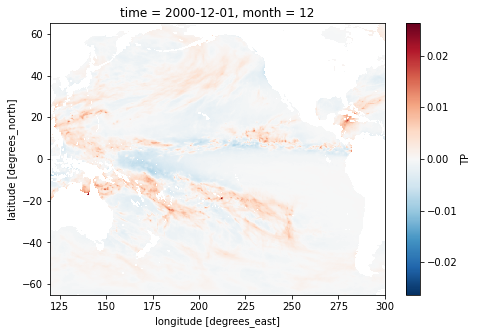

In [23]:
mask_precip.sel(time='2000-12-01', method='nearest').plot(size=5)

In [24]:
mask_precip

<xarray.DataArray 'TP' (time: 516, latitude: 521, longitude: 721)>
array([[[           nan,            nan,            nan, ...,
          1.4146538e-03,  1.3548607e-03,  1.2932711e-03],
        [           nan,            nan,            nan, ...,
          1.2891237e-03,  1.2950897e-03,  1.3049148e-03],
        [           nan,            nan,            nan, ...,
          1.1772333e-03,  1.1944881e-03,  1.2119426e-03],
        ...,
        [-8.8500977e-04, -8.7853370e-04, -8.7223493e-04, ...,
                    nan,            nan,            nan],
        [-8.6686772e-04, -8.5289532e-04, -8.3721511e-04, ...,
                    nan,            nan,            nan],
        [-7.2756479e-04, -7.0964464e-04, -6.9019408e-04, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
          1.9991009e-03,  2.0877705e-03,  2.1731132e-03],
        [           nan,            nan,            nan, ...,
          2.2057821e-03,  2.3874238e-03,  2.5889596e-03],
        [           nan,            nan,            nan, ...,
          2.5264830e-03,  2.7894531e-03,  3.0510039e-03],
...
        [-6.1665021e-04, -6.3119933e-04, -6.4776663e-04, ...,
                    nan,            nan,            nan],
        [-7.0126110e-04, -7.1410241e-04, -7.2694384e-04, ...,
                    nan,            nan,            nan],
        [-7.1754016e-04, -7.2984921e-04, -7.4371067e-04, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
          1.2422828e-03,  1.2700058e-03,  1.2982835e-03],
        [           nan,            nan,            nan, ...,
          1.2917408e-03,  1.2979507e-03,  1.3027635e-03],
        [           nan,            nan,            nan, ...,
          1.2558338e-03,  1.2549910e-03,  1.2540817e-03],
        ...,
        [ 3.6641059e-04,  3.0883518e-04,  2.5068328e-04, ...,
                    nan,            nan,            nan],
        [ 1.8008915e-04,  1.1082587e-04,  4.1229767e-05, ...,
                    nan,            nan,            nan],
        [-3.6195270e-05, -1.0162173e-04, -1.6141497e-04, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [25]:
anomalies = xr.DataArray()


# Problem 2

### Deseasonalize

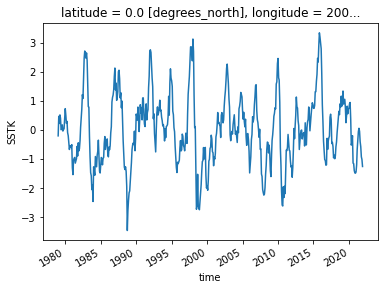

In [27]:
mask_SST.sel(latitude=0, longitude=200).plot()

#### Idea 1

In [28]:
#deseason = mask_SST.resample(time='AS').mean(dim='time') - mask_SST 

In [70]:
deseason_sst = mask_SST.groupby('time.month') - mask_SST.groupby('time.month').mean(dim='time')
deseason_precip = mask_precip.groupby('time.month') - mask_precip.groupby('time.month').mean(dim='time')

In [69]:
deseason_sst

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
array([[[           nan,            nan,            nan, ...,
         -8.1815496e-03, -1.3314181e-02, -1.8333258e-02],
        [           nan,            nan,            nan, ...,
         -1.3405024e-02, -2.0627044e-02, -2.7485693e-02],
        [           nan,            nan,            nan, ...,
         -1.7765488e-02, -2.5032930e-02, -3.2209530e-02],
        ...,
        [-3.0049169e-01, -3.0126384e-01, -3.0244482e-01, ...,
                    nan,            nan,            nan],
        [-8.5470223e-01, -8.4071243e-01, -8.2726765e-01, ...,
                    nan,            nan,            nan],
        [-8.3242303e-01, -8.3217317e-01, -8.4643555e-01, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
         -4.9963663e-04, -7.0403342e-04, -8.8571949e-04],
        [           nan,            nan,            nan, ...,
         -6.8132265e-04, -1.9077035e-03, -3.4974564e-03],
        [           nan,            nan,            nan, ...,
         -1.5216207e-03, -4.1787792e-03, -6.8132267e-03],
...
        [-1.9446084e-02, -2.1876136e-02, -2.4397029e-02, ...,
                    nan,            nan,            nan],
        [-6.9097476e-03, -8.0452850e-03, -9.1354018e-03, ...,
                    nan,            nan,            nan],
        [-8.6868642e-04, -1.4137445e-03, -1.4137445e-03, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
          9.3738645e-02,  6.3442498e-02,  3.2419603e-02],
        [           nan,            nan,            nan, ...,
          7.7591300e-02,  5.4108378e-02,  3.1147802e-02],
        [           nan,            nan,            nan, ...,
          7.6251365e-02,  5.8105469e-02,  4.0141262e-02],
        ...,
        [-1.1036292e-01, -8.4745184e-02, -6.0081303e-02, ...,
                    nan,            nan,            nan],
        [-3.0331349e-01, -2.8943723e-01, -2.7533385e-01, ...,
                    nan,            nan,            nan],
        [-1.4397484e-01, -1.3788836e-01, -1.4036383e-01, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

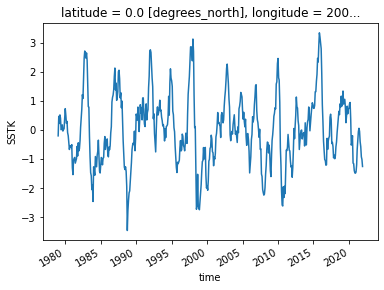

In [71]:
deseason_sst.sel(latitude=0, longitude=200).plot()

### Detrend

In [38]:
# # Detrend using the second deseason method...
# fig = plt.figure(figsize=(15, 7))
# layout = (3, 2)
# fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

# X = [i for i in range(0, len(deseason2))]
# X = np.reshape(X, (len(X), 1))
# y = deseason2.values
# model = LinearRegression()
# model.fit(X, y)
# # calculate trend
# trend = model.predict(X)
# fit_ax.plot(trend)
# fit_ax.set_title("Trend fitted by linear regression")

# # test = deseason.sel(latitude=0, longitude=200)

# # model = LinearRegression().fit(test, test.time)

In [76]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# -- Running mean
#ranm_sst = deseason_sst.rolling(time=12, center=True).mean('time')
detrend_sst = detrend_dim(deseason_sst,'time',1)

#ranm_precip = deseason_precip.rolling(time=12, center=True).mean('time')
detrend_precip = detrend_dim(deseason_precip,'time',1)

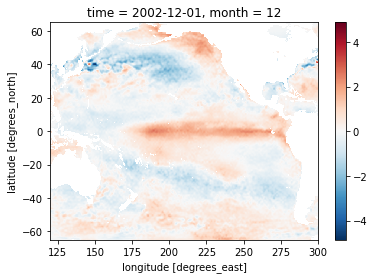

In [79]:
detrend_sst.sel(time='2002-12-01', method='nearest').plot()

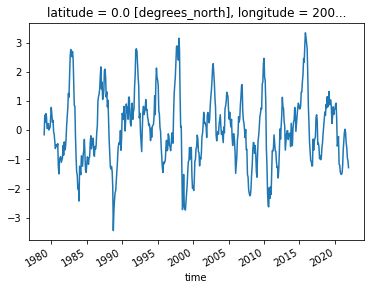

In [81]:
detrend_sst.sel(latitude=0, longitude=200).plot()

In [75]:
detrend_sst

<xarray.DataArray (time: 516, latitude: 521, longitude: 721)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### Standardize

In [44]:
# # Standardize????

# long_mean = detrend.mean()
# standard = detrend.std()

# standardize = (detrend - long_mean)/standard
# standardize.plot()

In [82]:
long_mean_sst = detrend_sst.groupby('time.month').mean(dim='time')
std_sst = detrend_sst.groupby('time.month').std(dim='time')
standardize_sst = (detrend_sst.groupby('time.month') - long_mean_sst)/std_sst
standardize_sst

: 

: 

In [ ]:
long_mean_precip = detrend_precip.groupby('time.month').mean(dim='time')
std_precip = detrend_precip.groupby('time.month').std(dim='time')
standardize_precip = (detrend_precip.groupby('time.month') - long_mean_precip)/std_precip
standardize_precip

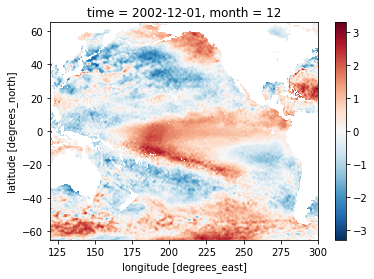

In [46]:
standardize.sel(time='2002-12-01', method='nearest').plot()

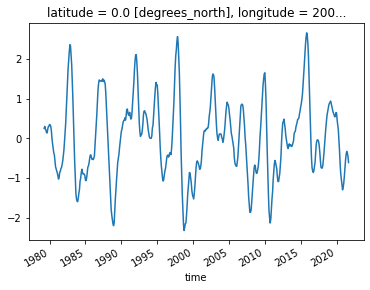

In [47]:
standardize.sel(latitude=0, longitude=200).plot()

# Problem 3

In [48]:
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [56]:
# Eof only works with original anomaly dataset, won't work after standardizing for some reason...

In [50]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(anom.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(anom, weights=wgts)

In [52]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
# eof1 = solver.eofsAsCorrelation(neofs=2)
# pc1 = solver.pcs(npcs=2, pcscaling=1)

eofs = solver.eofs(neofs=5)

In [54]:
eofs

<xarray.DataArray 'eofs' (mode: 5, latitude: 521, longitude: 721)>
array([[[            nan,             nan,             nan, ...,
          5.06283948e-04,  5.19868161e-04,  5.33274957e-04],
        [            nan,             nan,             nan, ...,
          5.19194698e-04,  5.33458020e-04,  5.48682874e-04],
        [            nan,             nan,             nan, ...,
          5.49389399e-04,  5.67563460e-04,  5.85480127e-04],
        ...,
        [-1.30981221e-04, -1.21567275e-04, -1.11902336e-04, ...,
                     nan,             nan,             nan],
        [-1.19758319e-04, -1.12095564e-04, -1.04348728e-04, ...,
                     nan,             nan,             nan],
        [-5.88197981e-05, -5.20251306e-05, -4.61451164e-05, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -1.08670560e-03, -1.09559449e-03, -1.10482029e-03],
        [            nan,             nan,             nan, ...,
         -1.02201512e-03, -1.01957121e-03, -1.00663153e-03],
        [            nan,             nan,             nan, ...,
         -1.10755244e-03, -1.06256956e-03, -1.01775187e-03],
...
                     nan,             nan,             nan],
        [-1.04447048e-04, -1.10121320e-04, -1.15740848e-04, ...,
                     nan,             nan,             nan],
        [-4.67649625e-05, -4.83416079e-05, -4.52762433e-05, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -4.64520126e-04, -5.18174493e-04, -5.73208847e-04],
        [            nan,             nan,             nan, ...,
         -5.62920992e-04, -5.61621040e-04, -5.68609685e-04],
        [            nan,             nan,             nan, ...,
         -5.61207009e-04, -5.90937270e-04, -6.20773702e-04],
        ...,
        [-1.57404720e-04, -1.58718831e-04, -1.59897128e-04, ...,
                     nan,             nan,             nan],
        [-6.90851375e-05, -7.77585010e-05, -8.61528169e-05, ...,
                     nan,             nan,             nan],
        [ 3.72377763e-05,  2.62861631e-05,  1.32812684e-05, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * mode       (mode) int64 0 1 2 3 4
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
Attributes:
    long_name:  empirical_orthogonal_functions

Text(0.5, 1.0, 'EOF1 expressed as correlation')

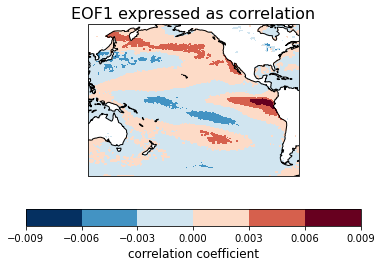

In [62]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eofs[4].plot.contourf(ax=ax, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)

In [64]:
client.close()